In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gpytorch

# ------------------ Load and Preprocess Data ------------------
# Normalize the data (zero mean, unit variance over the 10x10x100 subset)
data_np = np.load('spatial_temporal_data.npy')
data = data_np[50:60, 100:110, :100]
data_mean = data.mean()
data_std = data.std()
data = (data - data_mean) / data_std  # (10, 10, 100)

H, W, T = data.shape
x_grid, y_grid = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
locations = np.stack([x_grid.ravel(), y_grid.ravel()], axis=-1)

# ------------------ Fixed training locations (for fair comparison) ------------------
train_locs = np.array([
    (0, 0), (0, 4), (0, 9),
    (2, 2), (2, 7),
    (4, 0), (4, 5), (4, 9),
    (5, 7),
    (6, 2), (6, 7),
    (7, 0), (7, 5),
    (9, 4), (9, 9),
], dtype=int)

print("Trained spatial locations (x, y):", [tuple(loc) for loc in train_locs])

train_x_space = torch.tensor(train_locs, dtype=torch.float32)
train_x_time = torch.arange(T, dtype=torch.float32).unsqueeze(1)

train_inputs = []
train_outputs = []

for i, loc in enumerate(train_locs):
    x_idx, y_idx = loc
    ts = data[x_idx, y_idx]
    loc_tensor = train_x_space[i].repeat(T, 1)
    train_inputs.append(torch.cat([loc_tensor, train_x_time], dim=1))
    train_outputs.append(torch.tensor(ts, dtype=torch.float32))

train_x = torch.cat(train_inputs, dim=0)   # (15*100, 3)
train_y = torch.cat(train_outputs, dim=0)  # (15*100,)

# ------------------ Define GP Model ------------------
class SeparableGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        self.covar_module_space = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(active_dims=[0, 1])
        )

        self.covar_module_time = gpytorch.kernels.SpectralMixtureKernel(
            num_mixtures=4, active_dims=[2]
        )
        self.covar_module_time.initialize_from_data(train_x, train_y)
        # alternatively:
        # self.covar_module_time.initialize_from_data(train_x[:, 2:3], train_y)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module_space(x) * self.covar_module_time(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ------------------ Train GP ------------------
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SeparableGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# ------------------ Predict on Full Grid ------------------
test_inputs = []
for i in range(H):
    for j in range(W):
        spatial = torch.tensor([i, j], dtype=torch.float32).repeat(T, 1)
        temporal = train_x_time
        combined = torch.cat([spatial, temporal], dim=1)
        test_inputs.append(combined)

test_x = torch.cat(test_inputs, dim=0)  # (H*W*T, 3)

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(test_x))
    pred_mean = pred_dist.mean.reshape(H, W, T)


Trained spatial locations (x, y): [(0, 0), (0, 4), (0, 9), (2, 2), (2, 7), (4, 0), (4, 5), (4, 9), (5, 7), (6, 2), (6, 7), (7, 0), (7, 5), (9, 4), (9, 9)]


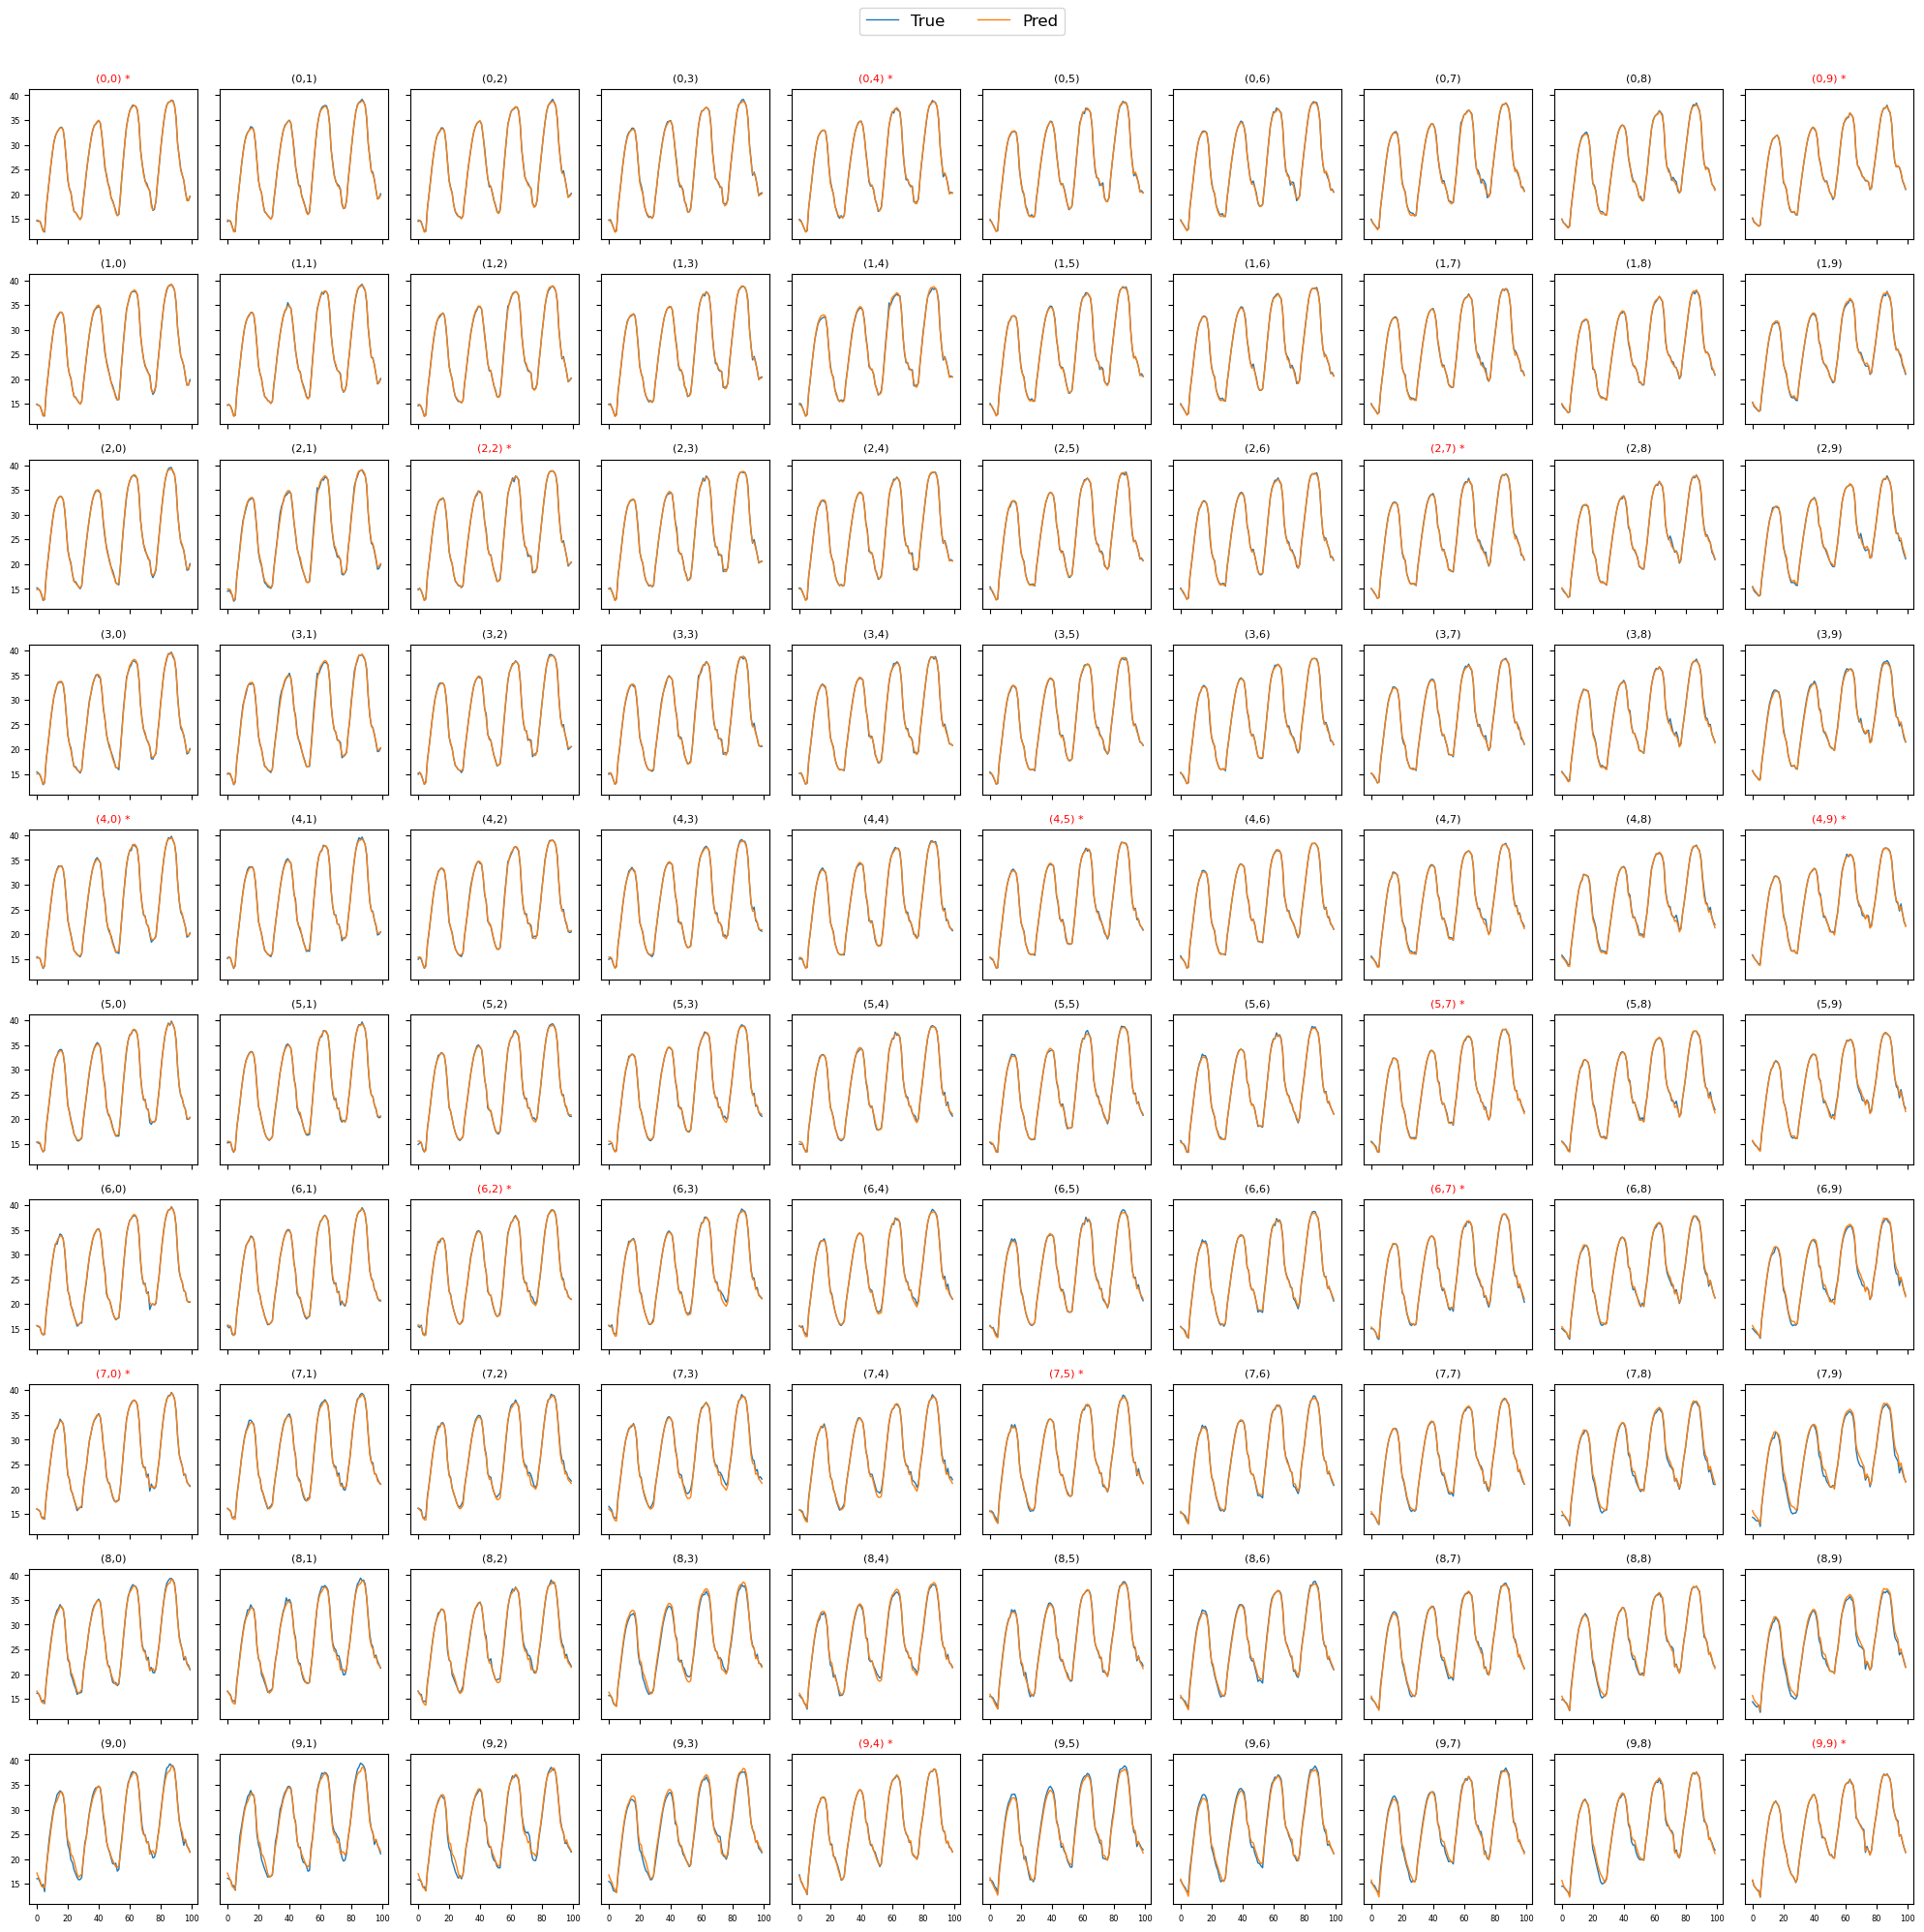

In [11]:
# Time series comparison for all locations (denormalized)
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        true_ts = data[i, j, :] * data_std + data_mean
        pred_ts = pred_mean[i, j, :] * data_std + data_mean

        axs[i, j].plot(true_ts, label='True', linewidth=1)
        axs[i, j].plot(pred_ts.detach().cpu().numpy(), label='Pred', linewidth=1)

        is_train = (i, j) in train_locs_set
        title = f'({i},{j})' + (' *' if is_train else '')

        axs[i, j].set_title(
            title,
            fontsize=8,
            color='red' if is_train else 'black'
        )
        axs[i, j].tick_params(labelsize=6)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


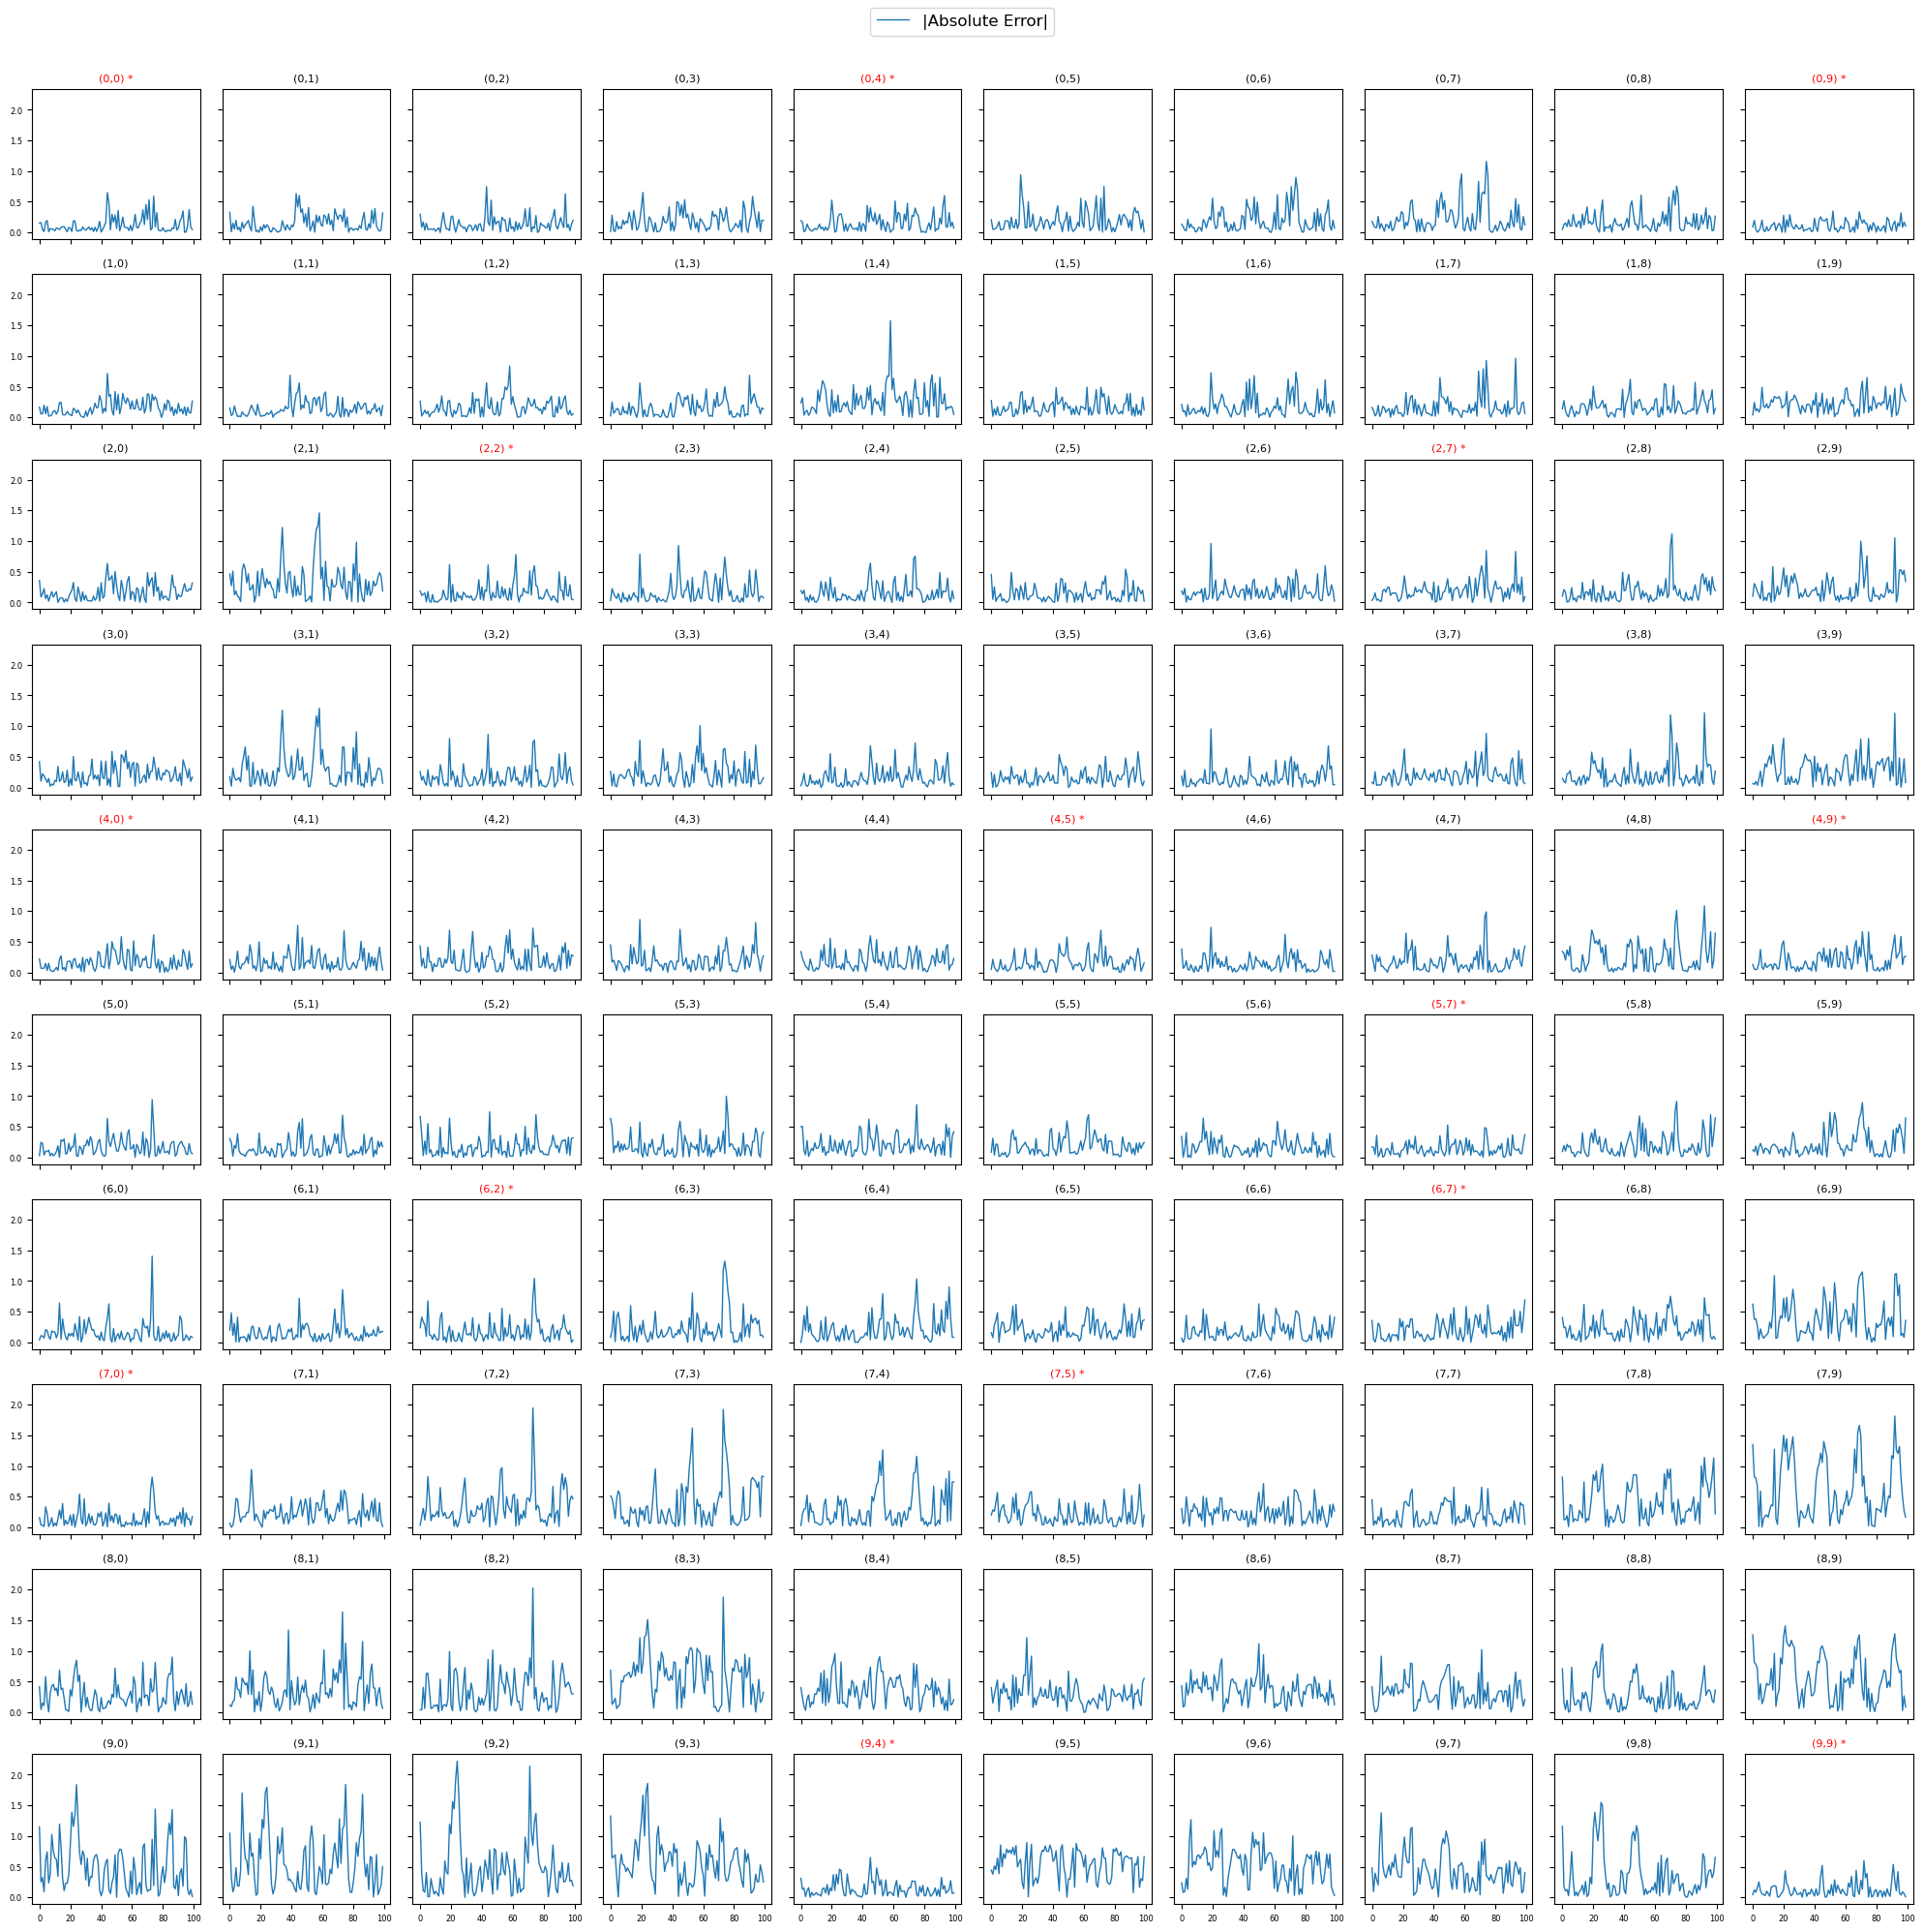

In [12]:
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        # Compute absolute error in normalized space, then scale to original units
        abs_err = torch.abs(
            pred_mean[i, j, :] - torch.tensor(data[i, j, :])
        ) * data_std
        abs_err = abs_err.detach().cpu().numpy()

        axs[i, j].plot(abs_err, label='|Error|', linewidth=1, color='tab:blue')

        is_train = (i, j) in train_locs_set
        title = f'({i},{j})' + (' *' if is_train else '')

        axs[i, j].set_title(
            title,
            fontsize=8,
            color='red' if is_train else 'black'
        )
        axs[i, j].tick_params(labelsize=6)

fig.legend(['|Absolute Error|'],
           loc='upper center', ncol=1, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Location (0,1): 0 points exceed 1.0
Location (5,9): 0 points exceed 1.0
Location (8,2): 2 points exceed 1.0


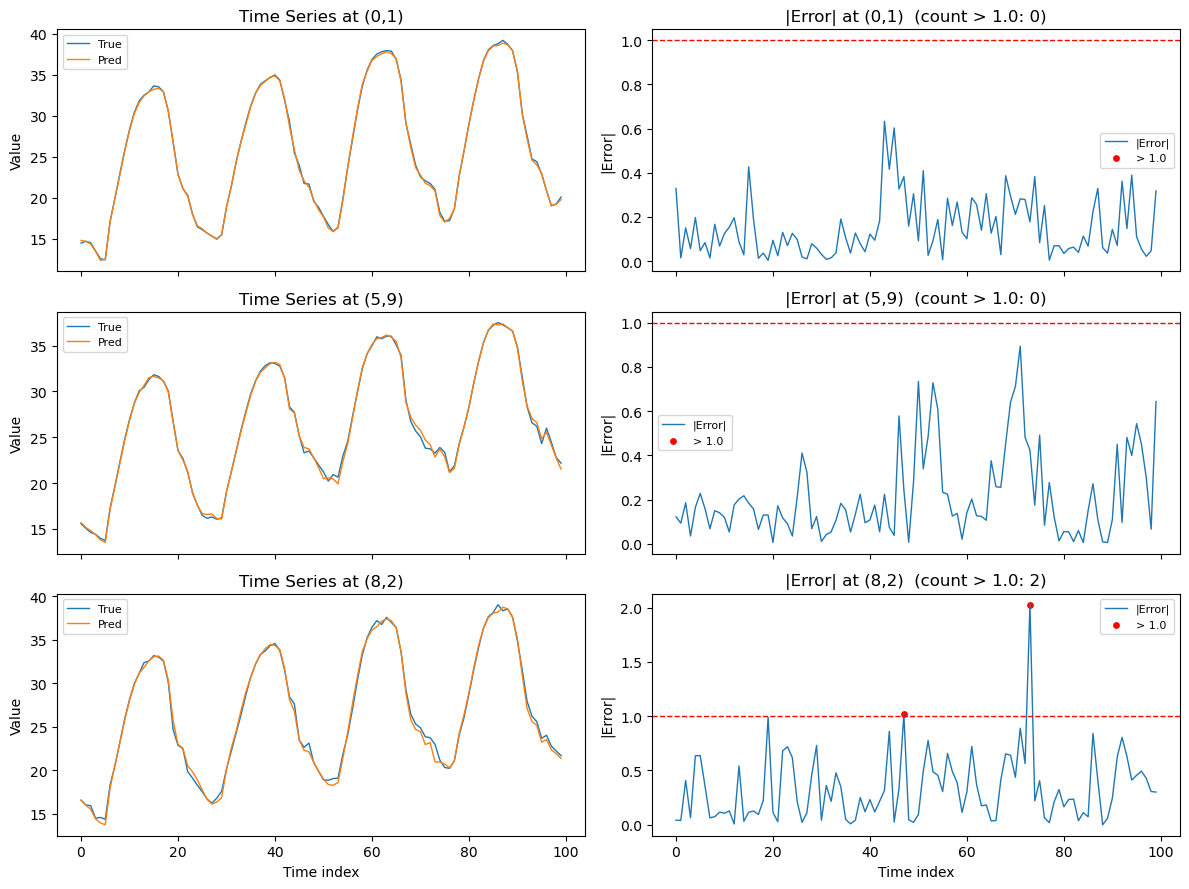

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Locations to inspect
locations = [(0, 1), (5, 9), (8, 2)]
threshold = 1.0

fig, axs = plt.subplots(len(locations), 2, figsize=(12, 3 * len(locations)), sharex=True)

for row, (i, j) in enumerate(locations):
    # ---- Denormalize true & predicted time series ----
    true_ts = data[i, j, :] * data_std + data_mean
    pred_ts = pred_mean[i, j, :].detach().cpu().numpy() * data_std + data_mean

    # ---- Absolute error (denormalized) ----
    abs_err = np.abs(pred_ts - true_ts)

    # ---- Count exceedances ----
    exceed_idx = abs_err > threshold
    num_exceed = np.sum(exceed_idx)

    print(f"Location ({i},{j}): {num_exceed} points exceed {threshold}")

    # ---- Plot true vs pred ----
    axs[row, 0].plot(true_ts, label="True", linewidth=1)
    axs[row, 0].plot(pred_ts, label="Pred", linewidth=1)
    axs[row, 0].set_title(f"Time Series at ({i},{j})")
    axs[row, 0].set_ylabel("Value")
    axs[row, 0].legend(fontsize=8)

    # ---- Plot absolute error ----
    axs[row, 1].plot(abs_err, label="|Error|", linewidth=1)
    axs[row, 1].axhline(threshold, color="red", linestyle="--", linewidth=1)

    # Mark exceedances
    axs[row, 1].scatter(
        np.where(exceed_idx)[0],
        abs_err[exceed_idx],
        color="red",
        s=15,
        label="> 1.0"
    )

    axs[row, 1].set_title(f"|Error| at ({i},{j})  (count > 1.0: {num_exceed})")
    axs[row, 1].set_ylabel("|Error|")
    axs[row, 1].legend(fontsize=8)

axs[-1, 0].set_xlabel("Time index")
axs[-1, 1].set_xlabel("Time index")

plt.tight_layout()
plt.show()
